In [2]:
# Cell 1 — Import libraries & load model/tokenizer

import os
import sys
import re
import numpy as np

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle

# FIXED → Correct path to src folder
sys.path.append(os.path.abspath("../src"))

# Import Member A's function
from data_preparation import prepare_data

MODEL_PATH = "../saved_model/sentiment_model.h5"
TOKENIZER_PATH = "../saved_model/tokenizer.pkl"
MAX_LEN = 120

model = load_model(MODEL_PATH)

with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully.")


Model and tokenizer loaded successfully.


In [4]:
#clean and predict 
def clean_text(text: str) -> str:
    """
    Normalise input: lowercase, remove non-alphanumeric chars,
    collapse multiple spaces. MUST match training + Flask.
    """
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def predict_sentiment(text: str):
    """
    Predict sentiment for a single input sentence.
    Returns (label, probability).
    """
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    seq = pad_sequences(
        seq,
        maxlen=MAX_LEN,
        padding="post",
        truncating="post"
    )
    prob = float(model.predict(seq, verbose=0)[0][0])
    label = "Positive" if prob >= 0.5 else "Negative"
    return label, prob

test_sentences = [
    "I really love this product so much",
    "This is the worst thing I have ever bought",
    "The quality is okay, not great but not terrible",
    "I am very disappointed with this chair",
    "Amazing value for money, highly recommended!"
]

for s in test_sentences:
    label, prob = predict_sentiment(s)
    print(f"Input: {s}")
    print(f" → Prediction: {label} ({prob:.4f})")
    print("-" * 60)


Input: I really love this product so much
 → Prediction: Positive (0.7037)
------------------------------------------------------------
Input: This is the worst thing I have ever bought
 → Prediction: Negative (0.0357)
------------------------------------------------------------
Input: The quality is okay, not great but not terrible
 → Prediction: Negative (0.0613)
------------------------------------------------------------
Input: I am very disappointed with this chair
 → Prediction: Negative (0.0913)
------------------------------------------------------------
Input: Amazing value for money, highly recommended!
 → Prediction: Positive (0.7693)
------------------------------------------------------------


In [10]:
# Cell 4 – Load dataset splits using your prepare_data()

import os
import numpy as np
from data_preparation import prepare_data

print("Current notebook path:", os.getcwd())

# Move to project root so 'data' folder exists
project_root = os.path.abspath("..")
print("Switching directory to:", project_root)
os.chdir(project_root)

# Call prepare_data() exactly as defined (no arguments)
result = prepare_data()

# Switch back to evaluation folder
eval_dir = os.path.abspath("./evaluation")
os.chdir(eval_dir)
print("Returned to evaluation directory:", os.getcwd())

# Unpack returned lists
X_train, X_val, X_test, y_train, y_val, y_test = result

# FIX: Convert lists to numpy arrays
X_train = np.array(X_train)
X_val   = np.array(X_val)
X_test  = np.array(X_test)

y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

print("Dataset loaded:")
print("  X_train:", X_train.shape, "| y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   "| y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  "| y_test:", y_test.shape)


Current notebook path: c:\Users\legia\GitHub\NLP-Project\NLP-Sentiment-Analysis-Group\evaluation
Switching directory to: c:\Users\legia\GitHub\NLP-Project\NLP-Sentiment-Analysis-Group
Loading dataset...
Total reviews after filtering: 7999
Shapes:
  X_train: (5599, 120) y_train: 5599
  X_val:   (1200, 120) y_val: 1200
  X_test:  (1200, 120) y_test: 1200
Returned to evaluation directory: c:\Users\legia\GitHub\NLP-Project\NLP-Sentiment-Analysis-Group\evaluation
Dataset loaded:
  X_train: (5599, 120) | y_train: (5599,)
  X_val:   (1200, 120) | y_val:   (1200,)
  X_test:  (1200, 120) | y_test: (1200,)


In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}")


Test Accuracy: 0.7133
Test Loss:     0.6464


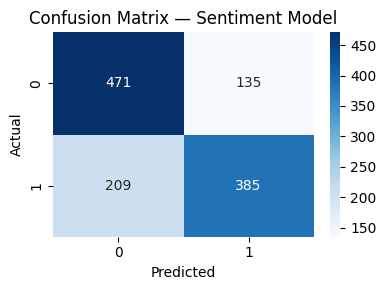


Classification report:
              precision    recall  f1-score   support

    Negative       0.69      0.78      0.73       606
    Positive       0.74      0.65      0.69       594

    accuracy                           0.71      1200
   macro avg       0.72      0.71      0.71      1200
weighted avg       0.72      0.71      0.71      1200



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_prob = model.predict(X_test, verbose=0).flatten()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Sentiment Model")
plt.tight_layout()
plt.show()

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))
